# Data Analysis and Baselines

This file serves as an evaluation of baselines for the evaluation of models on 
MNIST labels using the MUSE EEG dataset.  

In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

We first begin with some preliminary data analysis on the dataset and events. 
See the file `preprocessing.py` for more information on the process. Note that
we consider the event distribution and choose the first event derived. This
event is the one with the greatest amount of data samples, implying a degree
of generalizability to other event types.

In [5]:
from preprocess import load_fixedSize, returnEventDistribution, preprocessInputs

### Analyze the data. Consider events ordered by the number of samples we have.
eventDistribution = returnEventDistribution('MU')
print(eventDistribution)

### Where X represents input EEG data, Y represents OHE MNIST labels, and Y_raw
# represents the raw MNIST labels.
feature_size = 476
X, Y, Y_raw = load_fixedSize(feature_size, 'MU')
X = preprocessInputs(X)
feature_size = X.shape[1]
print('Feature Size: ', feature_size)

OrderedDict([(476, 51272), (460, 44432), (459, 32815), (493, 18504), (442, 9584), (510, 3308), (425, 2208), (527, 728), (408, 312), (544, 224), (561, 52), (474, 40), (461, 32), (438, 16), (468, 16), (478, 16), (457, 12), (472, 12), (497, 12), (470, 12), (467, 12), (492, 12), (473, 12), (464, 12), (479, 12), (480, 12), (465, 12), (490, 12), (456, 12), (446, 8), (506, 8), (495, 8), (463, 8), (444, 8), (477, 8), (462, 8), (485, 8), (475, 8), (454, 8), (491, 8), (443, 8), (484, 8), (471, 8), (452, 4), (486, 4), (449, 4), (578, 4), (482, 4), (508, 4), (458, 4), (488, 4), (483, 4), (469, 4), (455, 4), (440, 4), (439, 4), (501, 4), (536, 4), (612, 4), (450, 4), (481, 4), (453, 4), (487, 4), (448, 4), (524, 4), (445, 4), (451, 4), (498, 4), (509, 4)])
Preprocessing MU dataset...

Preprocessing complete.
Inputs shape: (51272, 476) || Labels shape: (51272, 10)
Feature Size:  476


We now visualize the distribution of labels (i.e. how many times the digits 0-9
appear as labels). We also visualize their corresponding EEG signals. Note the noisy
nature of the signals, even though they follow an apparent trend.

Below we plot the average signal of every single type. This is our representation
as way of seeing the average EEG signal for every single MNIST digit provided as
stimulus.

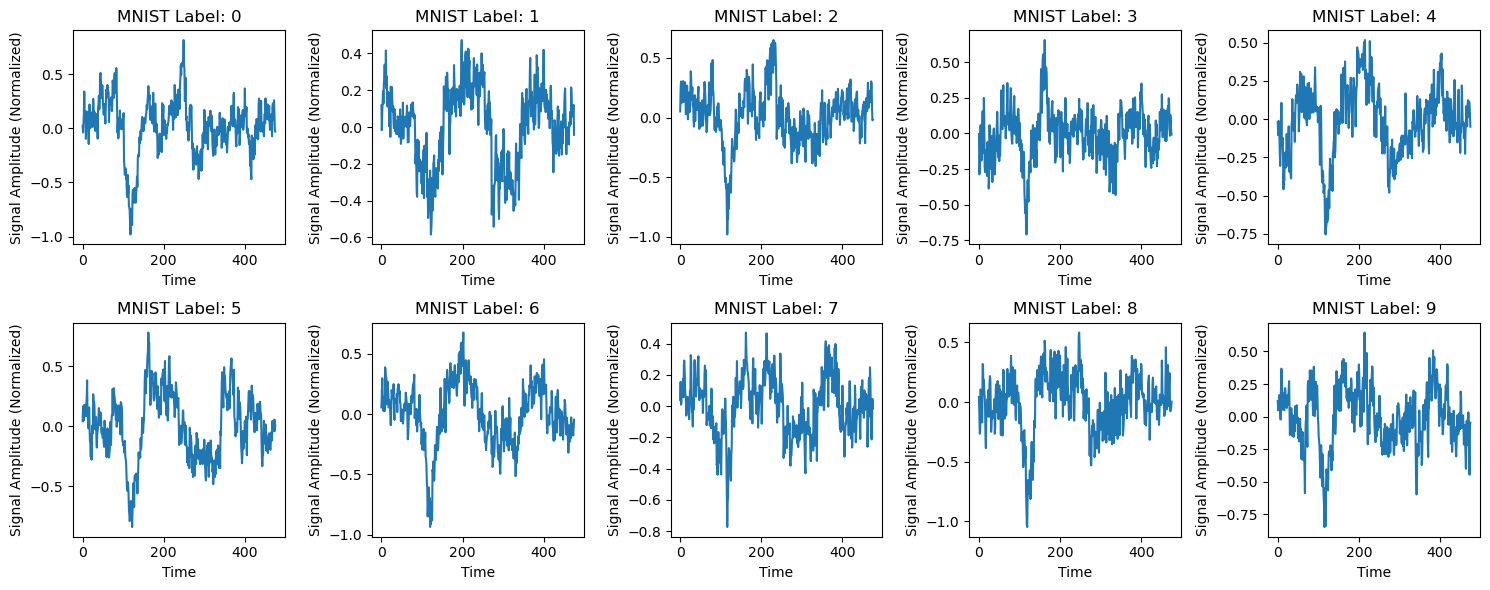

In [6]:
## Sanity Check on Data. 
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np

averaged_samples = defaultdict(list)

for signal, label in zip(X, Y_raw):
    averaged_samples[label].append(signal)

# Calculate the average of each label. This is the average signal for each label.
for label, signals in averaged_samples.items():
    averaged_signal = np.mean(signals, axis=0)
    averaged_samples[label] = averaged_signal

# Plot the averaged signals
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()
for i in range(10):
    averaged_signal, label = averaged_samples[i], i
    axes[i].plot(averaged_signal)
    axes[i].set_title(f"MNIST Label: {label}")
    axes[i].set_xlabel("Time")
    axes[i].set_ylabel("Signal Amplitude (Normalized)")

plt.tight_layout()
plt.show()

We now begin the model training process. We set up our dataloaders below.

In [7]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import numpy as np

# Split the data into train, validation, and test sets.
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.25, random_state=42) 
Y_train, Y_val, Y_test = np.float32(Y_train), np.float32(Y_val), np.float32(Y_test)

# Convert the data to PyTorch tensors.
X_train_tensor, X_val_tensor, X_test_tensor = torch.from_numpy(X_train), torch.from_numpy(X_val), torch.from_numpy(X_test)
Y_train_tensor, Y_val_tensor, Y_test_tensor = torch.from_numpy(Y_train), torch.from_numpy(Y_val), torch.from_numpy(Y_test)

# Create TensorDatasets for train and test sets.
train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
val_dataset   = TensorDataset(X_val_tensor, Y_val_tensor)
test_dataset  = TensorDataset(X_test_tensor, Y_test_tensor)

# Create DataLoader for train and test sets.
batch_size = 8
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### Multi-Layered Perceptron Baseline

We first run the model on an MLP. As the simplest of models, this gives us 
a good idea of the outputs that we expect at a baseline level. We expect the
accuracy to be on the level of random-guessing since the data is exceedingly
noisy. 

In [8]:
from models.baseline import mlp_Baseline
from torch import optim, nn

### Model Setup
mlp_model = mlp_Baseline(feature_size, 10)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Running on", device)
mlp_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mlp_model.parameters(), lr=0.001)

Running on cpu


In [21]:
### Training Loop
num_epochs = 10
mlp_epoch_train_losses = []
mlp_epoch_val_losses   = []
mlp_epoch_accuracies   = []

for epoch in range(num_epochs):
    epoch_train_loss = 0
    epoch_val_loss   = 0
    epoch_accuracy   = 0

    ## Training
    mlp_model.train()
    for (batchX, batchY) in train_dataloader:
        # Forward pass
        outputs = mlp_model(batchX)
        
        # Backward pass
        loss = criterion(outputs, batchY)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        epoch_train_loss += loss.item()
    
    ## Validation
    mlp_model.eval()
    with torch.no_grad():
        for (batchX, batchY) in val_dataloader:
            outputs = mlp_model(batchX)
            loss = criterion(outputs, batchY)
            epoch_val_loss += loss.item()
            
            pred, actual = outputs.detach().cpu().numpy(), batchY.detach().cpu().numpy()
            for a, b in zip(pred, actual):
                if np.argmax(a) == np.argmax(b):
                    epoch_accuracy += 1

    # Save and print losses
    epoch_train_loss /= len(train_dataloader)
    epoch_val_loss   /= len(val_dataloader)
    epoch_accuracy   /= len(val_dataloader)

    mlp_epoch_train_losses.append(epoch_train_loss)
    mlp_epoch_val_losses.append(epoch_val_loss)
    mlp_epoch_accuracies.append(epoch_accuracy)
    
    print(f"Epoch {epoch + 1} Training loss: {epoch_train_loss} || Validation loss: {epoch_val_loss} || Accuracy: {epoch_accuracy}")

Epoch 1 Training loss: 2.3020876070762513 || Validation loss: 2.302229784952125 || Accuracy: 0.1983229329173167
Epoch 2 Training loss: 2.3021571549412116 || Validation loss: 2.302229784952125 || Accuracy: 0.1983229329173167
Epoch 3 Training loss: 2.3021657130275615 || Validation loss: 2.302229784952125 || Accuracy: 0.1983229329173167
Epoch 4 Training loss: 2.302166492568287 || Validation loss: 2.302229784952125 || Accuracy: 0.1983229329173167
Epoch 5 Training loss: 2.3021509349811096 || Validation loss: 2.302229784952125 || Accuracy: 0.1983229329173167
Epoch 6 Training loss: 2.302151874521407 || Validation loss: 2.302229784952125 || Accuracy: 0.1983229329173167
Epoch 7 Training loss: 2.302153371053627 || Validation loss: 2.302229784952125 || Accuracy: 0.1983229329173167
Epoch 8 Training loss: 2.3021679881086463 || Validation loss: 2.302229784952125 || Accuracy: 0.1983229329173167
Epoch 9 Training loss: 2.3021603383809652 || Validation loss: 2.302229784952125 || Accuracy: 0.198322932917

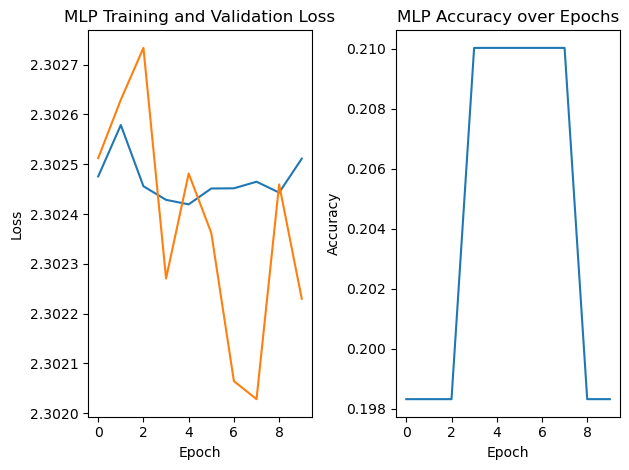

In [12]:
import matplotlib.pyplot as plt

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(mlp_epoch_train_losses)
plt.plot(mlp_epoch_val_losses)
plt.title('MLP Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(mlp_epoch_accuracies)
plt.title('MLP Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()


### Recurrent Neural Network Baseline

We then run the model on a recurrent neural network. This model gives us 
a good idea of the outputs that we expect at another baseline level. We expect
the accuracy to still be on the level of random-guessing since the data is
exceedingly noisy. It is possible that the accuracy will increase, but we 
expect most of the gains to be after pre-processing via our other methods.

In [17]:
from models.baseline import rnn_Baseline

### Model Setup
rnn_model = rnn_Baseline(64, 10)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Running on", device)
rnn_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(rnn_model.parameters(), lr=0.001)

Running on cpu


In [18]:
### Training Loop
num_epochs = 10
rnn_epoch_train_losses = []
rnn_epoch_val_losses   = []
rnn_epoch_accuracies   = []

for epoch in range(num_epochs):
    epoch_train_loss = 0
    epoch_val_loss   = 0
    epoch_accuracy   = 0

    ## Training
    rnn_model.train()
    for (batchX, batchY) in train_dataloader:
        # Forward pass
        outputs = rnn_model(batchX)

        # Backward pass
        loss = criterion(outputs, batchY)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        epoch_train_loss += loss.item()
    
    ## Validation
    rnn_model.eval()
    with torch.no_grad():
        for (batchX, batchY) in val_dataloader:
            outputs = rnn_model(batchX)
            loss = criterion(outputs, batchY)
            epoch_val_loss += loss.item()

            pred, actual = outputs.detach().cpu().numpy(), batchY.detach().cpu().numpy()
            for a, b in zip(pred, actual):
                if np.argmax(a) == np.argmax(b):
                    epoch_accuracy += 1

    # Save and print losses
    epoch_train_loss /= len(train_dataloader)
    epoch_val_loss   /= len(val_dataloader)
    epoch_accuracy   /= len(val_dataloader)

    rnn_epoch_train_losses.append(epoch_train_loss)
    rnn_epoch_val_losses.append(epoch_val_loss)
    rnn_epoch_accuracies.append(epoch_accuracy)
    
    print(f"Epoch {epoch + 1} Training loss: {epoch_train_loss} || Validation loss: {epoch_val_loss} || Accuracy: {epoch_accuracy}")

Epoch 1 Training loss: 2.3123120427813557 || Validation loss: 2.3089691145743667 || Accuracy: 0.3267773568085581
Epoch 2 Training loss: 2.2970537593819733 || Validation loss: 2.3180137738794695 || Accuracy: 0.31712447069311345
Epoch 3 Training loss: 2.2775981700240604 || Validation loss: 2.3289674976128683 || Accuracy: 0.32531479830621796
Epoch 4 Training loss: 2.247694511836355 || Validation loss: 2.341192622173595 || Accuracy: 0.3262341207934032
Epoch 5 Training loss: 2.215640231928228 || Validation loss: 2.353537689784016 || Accuracy: 0.3276548919099621
Epoch 6 Training loss: 2.1744503478364154 || Validation loss: 2.3733875974664076 || Accuracy: 0.33438266102072656
Epoch 7 Training loss: 2.1308318685567817 || Validation loss: 2.398035585322358 || Accuracy: 0.32209716960106977
Epoch 8 Training loss: 2.084371500193794 || Validation loss: 2.42673520885652 || Accuracy: 0.3180020057945175
Epoch 9 Training loss: 2.0414133541173634 || Validation loss: 2.4629022871462305 || Accuracy: 0.3098

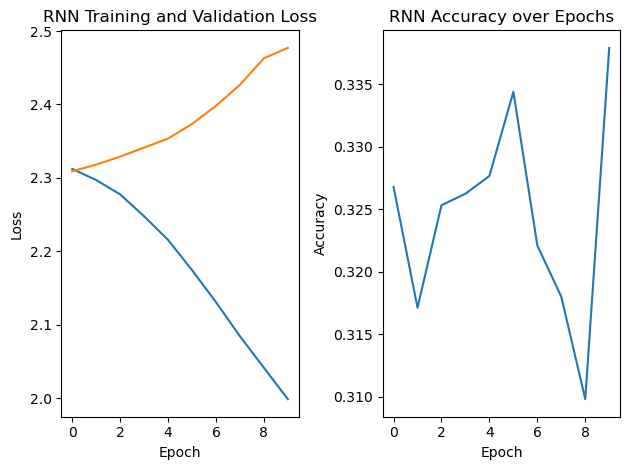

In [19]:
import matplotlib.pyplot as plt

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(rnn_epoch_train_losses)
plt.plot(rnn_epoch_val_losses)
plt.title('RNN Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(rnn_epoch_accuracies)
plt.title('RNN Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()

Note the incredible amounts of fluctations in results in both the MLP and RNN model.
The fluctations present even drop the model's performance to below baseline random
guessing of a 10% accuracy level, though the models sometimes perform better. This
is evidence of noisy data and further highlights the importance of pre-processing
techniques in the specific task of EEG.

Furthermore, note the poor performance of the RNN (despite the intuition that with
sequential signal data that a sequential RNN model should function better). This
overfitting trend is consistent with similar papers in the field (Mishra et al. 2021).

The `baseline.ipynb` file serves as a baseline analysis and can be compared with
other results from other notebook files. 